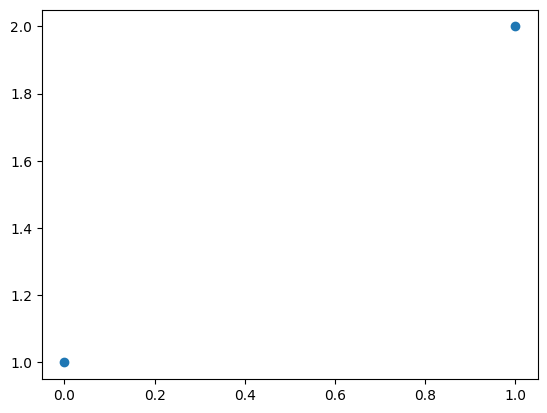

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward
import seis_test
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [13]:
importlib.reload(seis_test)
importlib.reload(seis_forward)
seis_test.run_all_tests(test_reference_mode=False)

3.544453883175856e-05


AssertionError: 

In [8]:
%debug

> f:\seismic\code\core\kaggle_support.py(274)from_vector()
    272 
    273     def from_vector(self, vec):
--> 274         assert vec.shape == (4901,1)
    275         self.data = cp.reshape(vec[:-1,0], (70,70))
    276         self.min_vel = vec[-1,0]



ipdb>  u


> f:\seismic\code\core\seis_test.py(39)test_stuff_on_one_case()
     37     for ii in range(N_test):
     38         vel_offset = copy.deepcopy(d.velocity)
---> 39         vel_offset.from_vector(vel_offset.to_vector() + offset_vecs[ii,:])
     40         offset_result = seis_forward.prep_run(vel_offset,3)
     41         for jj in range(len(offset_result)):



ipdb>  vel_offset.to_vector().shape


(4901, 1)


ipdb>  offset_vecs[ii,:].shape


(4901,)


ipdb>  offset_vecs[ii:ii+1,:].shape


(1, 4901)


ipdb>  q


In [ ]:
importlib.reload(kgs)
data = kgs.Data()
data.seismogram.filename = 'F:\\seismic\\data\\train_samples\\FlatVel_A/data\\data1.npy'
data.seismogram.ind=5
data.velocity = kgs.Velocity()
data.velocity.filename = 'F:\\seismic\\data\\train_samples\\FlatVel_A/model\\model1.npy'
data.velocity.ind=5
data.check_constraints()
data.load_to_memory()
#data.unload()

In [4]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()

10000


In [5]:
%%time
importlib.reload(seis_forward)
kgs.profiling=False
d = data[2059]
print(d.family)
d.load_to_memory()
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data, data[0].velocity.min_vel)
for ind in range(10):
    seis_pred = seis_forward.vel_to_seis(d.velocity, d.seismogram).data
    kgs.profiling=False
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data,data[0].velocity.min_vel)[:,2:,:]
kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:])    

CurveVel_A


AttributeError: 'tuple' object has no attribute 'data'

NameError: name 'seis_pred' is not defined

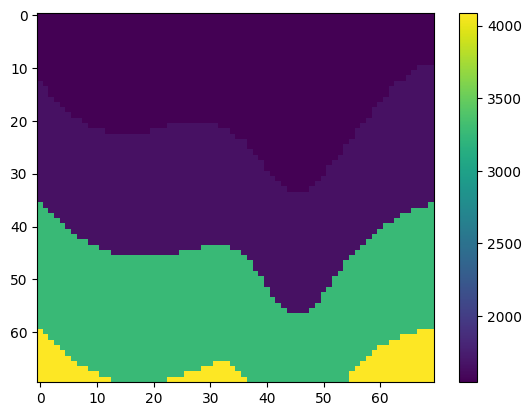

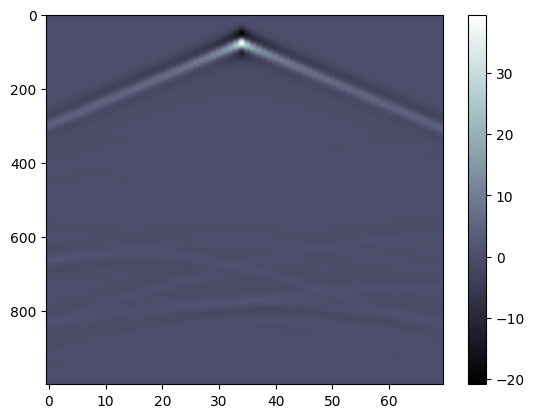

<Figure size 640x480 with 0 Axes>

In [6]:
import cupy as cp
plt.figure();plt.imshow(cp.asnumpy(d.velocity.data),aspect='auto');plt.colorbar()
plt.figure();plt.imshow(cp.asnumpy(d.seismogram.data[2,...]),cmap='bone',aspect='auto');plt.colorbar()        
plt.figure();plt.imshow(cp.asnumpy(seis_pred[2,...]),cmap='bone',aspect='auto');plt.colorbar()     
plt.figure();plt.imshow(cp.asnumpy(seis_pred[2,:,:]-d.seismogram.data[2,...]),cmap='bone',aspect='auto');plt.colorbar()

In [ ]:
data_shuffled = copy.deepcopy(data)
importlib.reload(seis_forward)
#np.random.default_rng(seed=0).shuffle(data_shuffled)
families = list(dict.fromkeys([d.family for d in data]))
for f in families:
    n_ok = 0
    n_done = 0
    for i,d in enumerate(data_shuffled):
        if not d.family==f:
            continue
        d.load_to_memory()
        seis_pred = seis_forward.vel_to_seis(d.velocity,d.seismogram)[0].data
        if kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:])<1e-4:
            #print('OK')
            n_ok+=1
        else:            
            pass
            print(d.family, kgs.rms(seis_pred[:,:,:]-d.seismogram.data[:,:,:]))              
            # plt.figure();plt.imshow(d.velocity.data,aspect='auto');plt.colorbar()
            # plt.figure();plt.imshow(d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()        
            # plt.figure();plt.imshow(seis_pred[2,:,:]-d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()
            # plt.pause(0.001)
            print(i)
        d.unload()
        n_done += 1
        if n_done>=100:
            break
    print(f,n_ok, n_done, n_ok/n_done)

In [ ]:
%debug